In [1]:
import pandas as pd
import numpy as np
import sqlite3 as lite
import sys
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy import stats
import seaborn as sns
sns.set(style="darkgrid")
import tensorflow as tf


%matplotlib inline



from scipy.interpolate import interp1d #For smooth plotting



In [2]:
con = None
users = []
data = pd.DataFrame()

In [3]:
ENVIRONMENTS = ['IN LAB', 'OUT LAB']
USER = 'Jeffrey Gonzales'

In [4]:
try:
    con = lite.connect('mouse.db')
       

    with con:
        cur = con.cursor() 

        # Get every entry in 
        query = "SELECT DISTINCT NAME FROM MOVEMENTS;"
        
        cur.execute(query)
        
        rows = cur.fetchall()

        
        for user in rows:
            users.append(user[0])
    
    if con:
        con.close()
        

        
except e:   
    print("Error :",e.args[0])
    con.close()


In [4]:
users

[]

In [5]:
#Test on one user
try:
    con = lite.connect('mouse.db')
    with con:
        cur = con.cursor()
        
        query = "SELECT * FROM MOVEMENTS WHERE NAME = '"+USER+"'"
        
        cur.execute(query)
        
        rows = cur.fetchall()
        data = pd.DataFrame(rows, columns=list(map(lambda x: x[0], cur.description)))
    
    if con:
        con.close()
    

except e:   
    print("Error :",e.args[0])
    con.close()

In [22]:
data = data.sort_values(by='TIMESTAMP', ascending=True)
data.head(7)

,TIMESTAMP,Y,X,TYPE,NAME,ENVIRONMENT
0,1412935718290,16,13,mousemove,Jeffrey Gonzales,OUT LAB
1,1412935718297,16,25,mousemove,Jeffrey Gonzales,OUT LAB
2,1412935718302,16,35,mousemove,Jeffrey Gonzales,OUT LAB
3,1412935718310,16,44,mousemove,Jeffrey Gonzales,OUT LAB
4,1412935718318,16,54,mousemove,Jeffrey Gonzales,OUT LAB
5,1412935718329,14,62,mousemove,Jeffrey Gonzales,OUT LAB
6,1412935718336,12,72,mousemove,Jeffrey Gonzales,OUT LAB


In [9]:
def distance(a,b):
    a = np.array(a)
    b = np.array(b)
    d = np.linalg.norm(a-b)
    return d

In [10]:
def distanceTravelled(chunk):
    totalDistance = 0
    
    prev_index = 0
    for i in range(1,len(chunk)):
        totalDistance = totalDistance + distance([chunk[i]["X"],chunk[i]["Y"]],[chunk[prev_index]["X"],chunk[prev_index]["X"]])
        prev_index = prev_index + 1
    return totalDistance
        

In [11]:
def optimalDistance(chunk):
    return distance([chunk[0]["X"],chunk[0]["Y"]],[chunk[-1]["X"],chunk[-1]["Y"]])
    

In [12]:
def sequenceEfficiency(chunk):
    return ((optimalDistance(chunk)/distanceTravelled(chunk))*100)

In [13]:
def sequenceSpeed(chunk):
    return distanceTravelled(chunk)/(abs(chunk[0]["TIMESTAMP"]-chunk[-1]["TIMESTAMP"])/1000)

In [14]:
def hoverTime(chunk):
    tempDf = pd.DataFrame(chunk).iloc[::-1]
    
    tempRows = []
    
    start = True
    x = 0
    y = 0
    for index, row in tempDf.iterrows():
        if(start):
            start = False
            x = row["X"]
            y = row["Y"]
            tempRows.append(row)
            continue
        if(x == row["X"] and y==row["Y"]):
            tempRows.append(row)
        else:
            break
        
#     if(len(tempRows)<2):
#         return abs(chunk[0]["TIMESTAMP"]-chunk[-1]["TIMESTAMP"])
    
        
    
    
    return abs(tempRows[0]["TIMESTAMP"]-tempRows[-1]["TIMESTAMP"])

In [15]:
def sequenceDuration(chunk):
    return (abs(chunk[0]["TIMESTAMP"]-chunk[-1]["TIMESTAMP"]))

In [137]:
#The Algorithm

df = data.loc[data['ENVIRONMENT'] == ENVIRONMENTS[0]]
df = df[df['TYPE']!='click']


finalChunks = []
tempChunks =[]

length = []
sequence = []
click_sequence_time = 0

chunks = []

def findMetrics():
    global sequence
    global length
    global chunks
    
    #Calculate Metrics here
    
    if(len(sequence)==0):
        return
    
#     print("Calculating ", len(sequence))
    length.append(len(sequence))
    chunks.append(sequence)
    
    #Set sequence to empty array
    sequence = []
    

def assess(row):
    global sequence

    
    #Check first if the array has atleast two elements
    if(len(sequence)>1):
        #Check sequence first and last time stamp 
        #If it is greater than 1450ms then ignore adding it to the sequence
        
        if(abs(sequence[0]["TIMESTAMP"]-sequence[-1]["TIMESTAMP"])>1500):
                findMetrics()
            
    
    if(row['TYPE']=="mousemove"):
        sequence.append(row)
        return
    if(row['TYPE']=="mouseDown"):
        sequence.append(row)
        return
    
    if(row['TYPE']=="mouseUp"):

        sequence.append(row)
        findMetrics()
        return


    




        
def processChunks():
    global chunks
    

    
    
    for x in chunks:
        
        if(len(x)<6):
            continue
        
        tempChunks.append(x)
        
    for i in range(0, len(tempChunks)):
        if(tempChunks[i][-1]["TYPE"]=="mouseUp"):
            finalChunks.append(tempChunks[i])

    saveData = []
        
    for x in finalChunks:
#         print("Efficiency", sequenceEfficiency(x),"\tDist", distanceTravelled(x),"\t","Opt Dist", optimalDistance(x),"\t")
#         print("Speed\t", sequenceSpeed(x),"px/s")
#         print("Hover Time\t", hoverTime(x),"milliseconds")
#         print("Sequence Duration\t", sequenceDuration(x))
        saveData.append([USER, ENVIRONMENTS[0], sequenceEfficiency(x),distanceTravelled(x),optimalDistance(x),sequenceSpeed(x),hoverTime(x),sequenceDuration(x)])
        
        
        
    saveDataFrame = pd.DataFrame(saveData, columns=['NAME', 'ENVIRONMENT', 'EFFICIENCY', 'DISTANCE_TRAVELLED','OPTIMAL_DISTANCE','SEQUENCE_SPEED','HOVER_TIME','SEQUENCE_DURATION'])
    print(len(saveDataFrame))
    saveDataFrame.to_pickle(USER+"-"+ENVIRONMENTS[0]+".pkl")

    

    
    
    

        
 

for index, row in df.iterrows():
    
    assess(row)

processChunks()

    
    

689


In [138]:
#The Algorithm

df = data.loc[data['ENVIRONMENT'] == ENVIRONMENTS[1]]
df = df[df['TYPE']!='click']


finalChunks = []
tempChunks =[]

length = []
sequence = []
click_sequence_time = 0

chunks = []

def findMetrics():
    global sequence
    global length
    global chunks
    
    #Calculate Metrics here
    
    if(len(sequence)==0):
        return
    
#     print("Calculating ", len(sequence))
    length.append(len(sequence))
    chunks.append(sequence)
    
    #Set sequence to empty array
    sequence = []
    

def assess(row):
    global sequence

    
    #Check first if the array has atleast two elements
    if(len(sequence)>1):
        #Check sequence first and last time stamp 
        #If it is greater than 1450ms then ignore adding it to the sequence
        
        if(abs(sequence[0]["TIMESTAMP"]-sequence[-1]["TIMESTAMP"])>4500):
                findMetrics()
            
    
    if(row['TYPE']=="mousemove"):
        sequence.append(row)
        return
    if(row['TYPE']=="mouseDown"):
        sequence.append(row)
        return
    
    if(row['TYPE']=="mouseUp"):

        sequence.append(row)
        findMetrics()
        return


    




        
def processChunks():
    global chunks
    

    
    
    for x in chunks:
        
        if(len(x)<6):
            continue
        
        tempChunks.append(x)
        
    for i in range(0, len(tempChunks)):
        if(tempChunks[i][-1]["TYPE"]=="mouseUp"):
            finalChunks.append(tempChunks[i])

    saveData = []
        
    for x in finalChunks:
#         print("Efficiency", sequenceEfficiency(x),"\tDist", distanceTravelled(x),"\t","Opt Dist", optimalDistance(x),"\t")
#         print("Speed\t", sequenceSpeed(x),"px/s")
#         print("Hover Time\t", hoverTime(x),"milliseconds")
#         print("Sequence Duration\t", sequenceDuration(x))
        saveData.append([USER, ENVIRONMENTS[1], sequenceEfficiency(x),distanceTravelled(x),optimalDistance(x),sequenceSpeed(x),hoverTime(x),sequenceDuration(x)])
        
        
        
    saveDataFrame = pd.DataFrame(saveData, columns=['NAME', 'ENVIRONMENT', 'EFFICIENCY', 'DISTANCE_TRAVELLED','OPTIMAL_DISTANCE','SEQUENCE_SPEED','HOVER_TIME','SEQUENCE_DURATION'])
    print(len(saveDataFrame))
    saveDataFrame.to_pickle(USER+"-"+ENVIRONMENTS[1]+".pkl")

    

    
    
    

        
 

for index, row in df.iterrows():
    
    assess(row)

processChunks()

    
    

1919


In [23]:
inlab = pd.read_pickle(USER+"-"+ENVIRONMENTS[0]+".pkl")
outlab  = pd.read_pickle(USER+"-"+ENVIRONMENTS[1]+".pkl")

In [24]:
inlab.describe()

,EFFICIENCY,DISTANCE_TRAVELLED,OPTIMAL_DISTANCE,SEQUENCE_SPEED,HOVER_TIME,SEQUENCE_DURATION
count,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000
mean,0.886567,17866.578634,114.587983,18161.771168,277.642961,953.345428
std,1.707733,16612.911842,174.954157,13807.021420,301.943121,474.767715
min,0.001609,42.798616,1.000000,47.766313,0.000000,147.000000
25%,0.207225,5505.233767,20.000000,7374.518750,168.000000,617.000000
50%,0.405157,12888.042033,46.690470,13799.293813,232.000000,912.000000
75%,0.912614,26088.643101,110.168053,25901.839112,312.000000,1257.000000
max,23.883041,114035.958716,1083.055862,85337.628647,5288.000000,6391.000000


In [25]:
outlab.describe()

,EFFICIENCY,DISTANCE_TRAVELLED,OPTIMAL_DISTANCE,SEQUENCE_SPEED,HOVER_TIME,SEQUENCE_DURATION
count,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000,1919.000000
mean,1.298761,38351.323111,279.909396,19928.256446,293.149557,1931.282960
std,2.397846,43623.130267,324.741524,17000.722170,284.051790,1151.511944
min,0.000000,74.095237,0.000000,65.929789,0.000000,119.000000
25%,0.218045,10454.557655,39.560081,7608.984704,163.000000,983.000000
50%,0.586407,22704.019277,126.826653,14773.749486,240.000000,1723.000000
75%,1.552993,49560.008086,429.814940,26430.790785,337.000000,2719.000000
max,44.719948,359602.747996,2066.610752,121044.341710,4785.000000,8056.000000


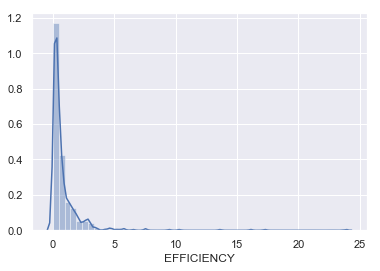

In [26]:
sns.distplot(inlab.EFFICIENCY)
plt.show()

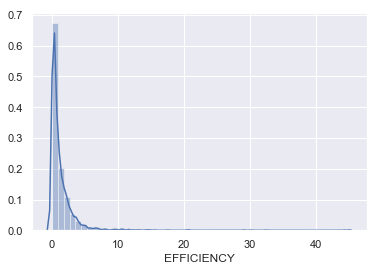

In [27]:
sns.distplot(outlab.EFFICIENCY)
plt.show()

In [28]:
stats.ttest_ind(inlab.SEQUENCE_SPEED, outlab.SEQUENCE_SPEED, equal_var=False) #Significant

Ttest_indResult(statistic=-2.7023813436247157, pvalue=0.0069629905374539421)

In [29]:
stats.ttest_ind(inlab.HOVER_TIME, outlab.HOVER_TIME, equal_var=False)

Ttest_indResult(statistic=-1.1743134074982078, pvalue=0.24051201150390414)

In [30]:
stats.ttest_ind(inlab.EFFICIENCY, outlab.EFFICIENCY, equal_var=False) #Significant

Ttest_indResult(statistic=-4.848037768257254, pvalue=1.3604976647106015e-06)

In [31]:
stats.ttest_ind(inlab.DISTANCE_TRAVELLED, outlab.DISTANCE_TRAVELLED, equal_var=False) #Significant

Ttest_indResult(statistic=-17.361106629568674, pvalue=5.7615615993958509e-64)

In [32]:
inlab.describe()

,EFFICIENCY,DISTANCE_TRAVELLED,OPTIMAL_DISTANCE,SEQUENCE_SPEED,HOVER_TIME,SEQUENCE_DURATION
count,689.000000,689.000000,689.000000,689.000000,689.000000,689.000000
mean,0.886567,17866.578634,114.587983,18161.771168,277.642961,953.345428
std,1.707733,16612.911842,174.954157,13807.021420,301.943121,474.767715
min,0.001609,42.798616,1.000000,47.766313,0.000000,147.000000
25%,0.207225,5505.233767,20.000000,7374.518750,168.000000,617.000000
50%,0.405157,12888.042033,46.690470,13799.293813,232.000000,912.000000
75%,0.912614,26088.643101,110.168053,25901.839112,312.000000,1257.000000
max,23.883041,114035.958716,1083.055862,85337.628647,5288.000000,6391.000000


In [33]:
combined = pd.concat([inlab, outlab.sample(n=inlab['ENVIRONMENT'].count())])
combined = combined.iloc[::-1]

In [36]:
combined = pd.concat([inlab, outlab])
combined = combined.iloc[::-1]

In [37]:
combined.head()
combined.describe()

,EFFICIENCY,DISTANCE_TRAVELLED,OPTIMAL_DISTANCE,SEQUENCE_SPEED,HOVER_TIME,SEQUENCE_DURATION
count,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000
mean,1.189865,32939.517534,236.233608,19461.573794,289.052914,1672.924463
std,2.243385,39426.899671,301.626978,16234.368754,288.908410,1104.990770
min,0.000000,42.798616,0.000000,47.766313,0.000000,119.000000
25%,0.213111,8510.546055,33.094556,7587.260773,164.000000,812.750000
50%,0.519676,19527.359974,88.150347,14384.862824,239.000000,1375.500000
75%,1.378110,41058.730533,378.531688,26429.181128,328.250000,2283.250000
max,44.719948,359602.747996,2066.610752,121044.341710,5288.000000,8056.000000


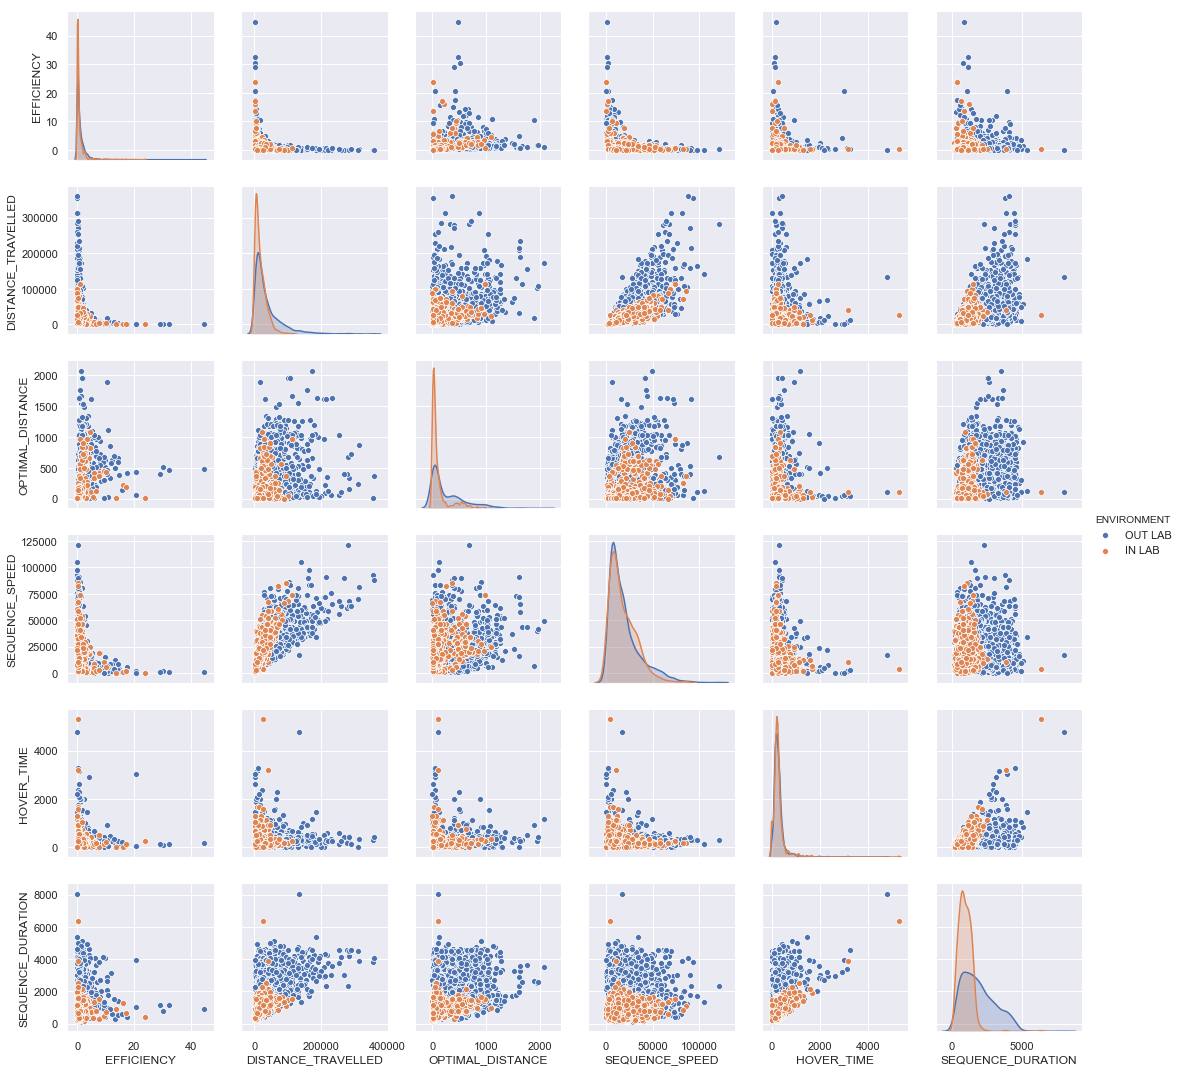

In [38]:
sns.pairplot(combined, hue='ENVIRONMENT')
plt.show()

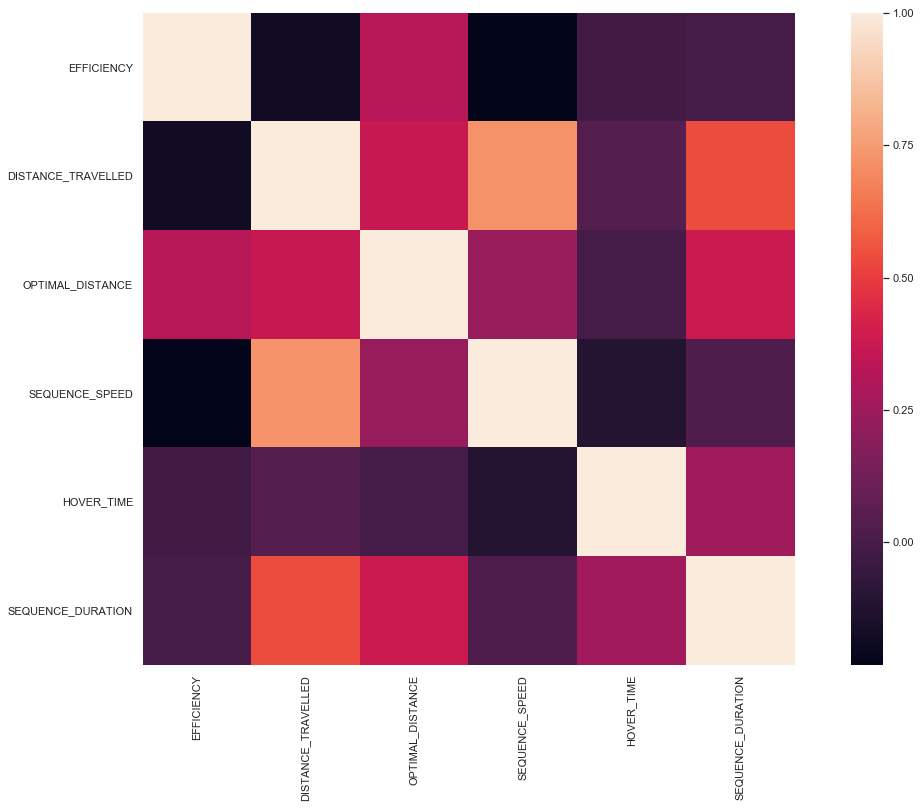

In [39]:
combined = combined.iloc[::-1]
corr_mat = combined.corr() 
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax)
plt.show()

### Using Tensorflow for Implementing Dense Neural Network

In [40]:
dataset = combined

In [41]:
def encode(x):
    if( x=='IN LAB'):
        return 1
    else: 
        return 0

In [42]:

dataset["ENVIRONMENT"] = dataset['ENVIRONMENT'].apply(encode)

In [43]:
dataset.head()

,NAME,ENVIRONMENT,EFFICIENCY,DISTANCE_TRAVELLED,OPTIMAL_DISTANCE,SEQUENCE_SPEED,HOVER_TIME,SEQUENCE_DURATION
0,Jeffrey Gonzales,1,0.030523,24951.049622,7.615773,21398.841872,15,1166
1,Jeffrey Gonzales,1,0.158782,6783.106611,10.770330,10483.936029,280,647
2,Jeffrey Gonzales,1,7.568568,4780.091598,361.784466,3180.366998,521,1503
3,Jeffrey Gonzales,1,0.493902,3037.041323,15.000000,8459.725134,136,359
4,Jeffrey Gonzales,1,1.032998,32816.969135,338.998525,41021.211419,168,800


### Balancing the class before classification

In [44]:
# from collections import Counter

# from sklearn.datasets import fetch_20newsgroups
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import make_pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
# from imblearn.metrics import classification_report_imbalanced

# print(__doc__)

In [45]:
cols_to_norm = ['EFFICIENCY', 'DISTANCE_TRAVELLED',
       'OPTIMAL_DISTANCE', 'SEQUENCE_SPEED', 'HOVER_TIME',
       'SEQUENCE_DURATION']

In [46]:
dataset[cols_to_norm] = dataset[cols_to_norm].apply(lambda x: (x- x.min())/(x.max()-x.min()))

In [47]:

def addWeight(x):
    if(x == 1):
        return 1/np.mean(combined.ENVIRONMENT == 1)
    else:
        return 1

dataset["WEIGHTS"] = dataset["ENVIRONMENT"]
dataset["WEIGHTS"] = dataset["WEIGHTS"].apply(addWeight)

#### Normalised Columns

In [48]:
dataset.head()

,NAME,ENVIRONMENT,EFFICIENCY,DISTANCE_TRAVELLED,OPTIMAL_DISTANCE,SEQUENCE_SPEED,HOVER_TIME,SEQUENCE_DURATION,WEIGHTS
0,Jeffrey Gonzales,1,0.000683,0.069274,0.003685,0.176460,0.002837,0.131914,3.785196
1,Jeffrey Gonzales,1,0.003551,0.018746,0.005212,0.086252,0.052950,0.066524,3.785196
2,Jeffrey Gonzales,1,0.169244,0.013175,0.175062,0.025890,0.098525,0.174373,3.785196
3,Jeffrey Gonzales,1,0.011044,0.008328,0.007258,0.069522,0.025719,0.030238,3.785196
4,Jeffrey Gonzales,1,0.023099,0.091151,0.164036,0.338633,0.031770,0.085801,3.785196


In [49]:
dataset.columns

Index(['NAME', 'ENVIRONMENT', 'EFFICIENCY', 'DISTANCE_TRAVELLED',
       'OPTIMAL_DISTANCE', 'SEQUENCE_SPEED', 'HOVER_TIME', 'SEQUENCE_DURATION',
       'WEIGHTS'],
      dtype='object')

In [50]:
EFFICIENCY = tf.feature_column.numeric_column('EFFICIENCY')
DISTANCE_TRAVELLED = tf.feature_column.numeric_column('DISTANCE_TRAVELLED')
OPTIMAL_DISTANCE = tf.feature_column.numeric_column('OPTIMAL_DISTANCE')
SEQUENCE_SPEED = tf.feature_column.numeric_column('SEQUENCE_SPEED')
HOVER_TIME = tf.feature_column.numeric_column('HOVER_TIME')
SEQUENCE_DURATION = tf.feature_column.numeric_column('SEQUENCE_DURATION')
WEIGHTS = tf.feature_column.numeric_column('WEIGHTS')

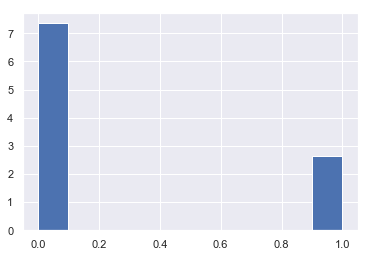

In [51]:
dataset['ENVIRONMENT'].hist(normed=1)

In [52]:
dataset.loc[dataset['ENVIRONMENT']==0].count()/dataset.count()

NAME                  0.735813
ENVIRONMENT           0.735813
EFFICIENCY            0.735813
DISTANCE_TRAVELLED    0.735813
OPTIMAL_DISTANCE      0.735813
SEQUENCE_SPEED        0.735813
HOVER_TIME            0.735813
SEQUENCE_DURATION     0.735813
WEIGHTS               0.735813
dtype: float64

In [53]:
x_data = dataset.drop(['NAME','ENVIRONMENT'], axis=1)

In [54]:
labels = dataset['ENVIRONMENT']

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [267]:
X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.3, random_state=101)

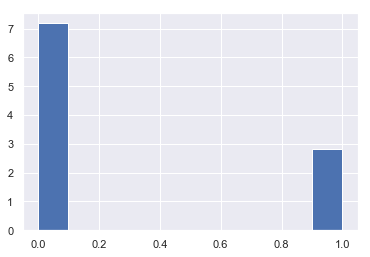

In [268]:
y_test.hist(normed=1)

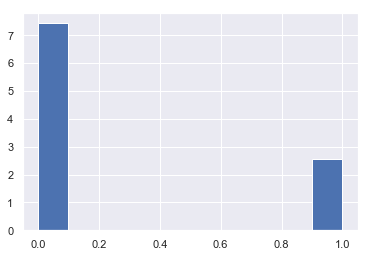

In [269]:
y_train.hist(normed=1)

In [270]:
feat_cols = [EFFICIENCY, DISTANCE_TRAVELLED,
       OPTIMAL_DISTANCE, SEQUENCE_SPEED, HOVER_TIME,
       SEQUENCE_DURATION]

In [271]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [272]:
input_func = tf.estimator.inputs.pandas_input_fn(X_train, y_train, batch_size=10, num_epochs=1000, shuffle=True )

In [273]:
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10], 
                                       feature_columns=feat_cols,
                                       n_classes=2, weight_column=WEIGHTS, model_dir='./tfgrapghs/new/')

In [276]:
dnn_model.train(input_fn=input_func, max_steps=2000)

In [277]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, y=y_test, batch_size=10, num_epochs=20, shuffle=False)

In [278]:
res = dnn_model.evaluate(eval_input_func)


In [279]:
print("Accuracy",res['accuracy'])
print("Area Under the curve",res['auc'])
print("AUC Precision Recall",res['auc_precision_recall'])

Accuracy 0.803178
Area Under the curve 0.797881
AUC Precision Recall 0.789718


In [280]:
res

{'accuracy': 0.80317849,
 'accuracy_baseline': 0.5966289,
 'auc': 0.79788065,
 'auc_precision_recall': 0.78971767,
 'average_loss': 0.44302717,
 'global_step': 11001,
 'label/mean': 0.5966289,
 'loss': 7.8971739,
 'prediction/mean': 0.56410176}